# Modelling to Generate Alternatives

In this example, we apply MGA ('modelling to generate alternatives') to a single node capacity expansion model in the style of [model.energy](https://model.energy).

The MGA algorithm, which can be called with `n.optimize.optimize_mga()`, tries to minimize or maximize investment or dispatch in (groups of) technologies within a set cost budget.

For instance, it can be used to minimize the amount of wind capacity while keeping costs within 5% of the cost-optimal solution in terms of system costs.

:::{note}
See also https://model.energy and [this paper](https://doi.org/10.1016/j.epsr.2020.106690) which uses PyPSA for MGA-type analysis.
:::

In [1]:
import pandas as pd

import pypsa

## Solve example network to cost-optimality

Running MGA requires knowledge of what the total system costs are in the optimum. So first, we need to solve for the cost-optimal solution.

In [4]:
# n = pypsa.examples.model_energy()
n = pypsa.Network("../model-energy/model-energy.nc")
n.optimize(solver_name="highs")
n.statistics.capex().sum() + n.statistics.opex().sum()

INFO:pypsa.io:Imported network model-energy.nc has buses, carriers, generators, links, loads, storage_units, stores
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 11/11 [00:00<00:00, 153.20it/s]
INFO:linopy.io: Writing time: 0.47s


Running HiGHS 1.10.0 (git hash: fd86653): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-4kifuvxc has 64246 rows; 29206 cols; 124144 nonzeros
Coefficient ranges:
  Matrix [2e-04, 3e+00]
  Cost   [1e+02, 2e+05]
  Bound  [0e+00, 0e+00]
  RHS    [5e+03, 1e+04]
Presolving model
33618 rows, 27784 cols, 92094 nonzeros  0s
Dependent equations search running on 8760 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
30698 rows, 24864 cols, 86254 nonzeros  0s
Presolve : Reductions: rows 30698(-33548); columns 24864(-4342); elements 86254(-37890)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 2920(1.67832e+07) 0s
      13517     1.5238085480e+09 Pr: 6306(1.74492e+10); Du: 0(1.42308e-07) 5s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 29206 primals, 64246 duals
Objective: 8.08e+09
Solver model: available
Solver message: optimal



      18537     8.0781356755e+09 Pr: 0(0); Du: 0(2.1366e-11) 10s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-4kifuvxc
Model status        : Optimal
Simplex   iterations: 18537
Objective value     :  8.0781356755e+09
Relative P-D gap    :  1.6527873467e-15
HiGHS run time      :          9.89
Writing the solution to /tmp/linopy-solve-1toy0okn.sol


INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


np.float64(8078135675.45125)

## Extract cost-optimal results

Optimal total system cost by technology:

In [5]:
tsc = (
    pd.concat([n.statistics.capex(), n.statistics.opex()], axis=1).sum(axis=1).div(1e9)
)
optimal_cost = tsc.sum()
tsc

component    carrier         
Link         electrolysis        0.570894
             turbine             1.172438
Generator    solar               1.341015
             wind                3.300830
StorageUnit  battery storage     0.941196
Store        hydrogen storage    0.561618
Generator    load shedding       0.190144
dtype: float64

The optimised capacities in GW (GWh for `Store` component):

In [6]:
n.statistics.optimal_capacity().div(1e3)

component    carrier         
Link         electrolysis           3.025153
             turbine               10.073615
Generator    load shedding         10.901160
             solar                 26.116801
             wind                  32.474381
StorageUnit  battery storage       14.854330
Store        hydrogen storage    3786.558312
dtype: float64

Energy balances on electricity side (in TWh):

In [7]:
n.statistics.energy_balance(bus_carrier="electricity").sort_values().div(1e6)

component    carrier          bus_carrier
Load         -                electricity   -66.266089
Link         electrolysis     electricity   -15.295140
StorageUnit  battery storage  electricity    -0.750055
Generator    load shedding    electricity     0.095072
Link         turbine          electricity     3.898685
Generator    solar            electricity    25.947720
             wind             electricity    52.369807
dtype: float64

Energy balances plot as time series (in MW):

(<Figure size 758.25x300 with 1 Axes>,
 <Axes: xlabel='snapshot', ylabel='Energy Balance []'>,
 <seaborn.axisgrid.FacetGrid at 0x7187edfb8590>)

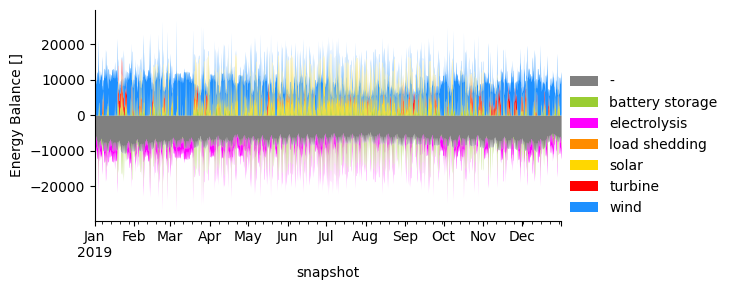

In [8]:
n.statistics.energy_balance.plot.area(linewidth=0, bus_carrier="electricity")

## Find lowest wind capacity within 5% cost slack

The function `n.optimize.optimize_mga` takes three main arguments:
1. The `slack` for the allowed relative cost deviation from the cost-optimum (0.05 corresponds to 5%).
2. A dictionary of weights for defining the new objective function. The first level defines the component (e.g. "Generator"), the second level defines the optimisation variable (e.g. `p_nom` for investment), and the third level defines the component name (e.g. from `n.generators.index`).
3. The `sense`, noting whether to minimizes ("min") or maximize ("max") the new objective.

In [9]:
weights = dict(Generator=dict(p_nom={"wind": 1}))
n.optimize.optimize_mga(slack=0.05, weights=weights, sense="min", solver_name="highs")

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 11/11 [00:00<00:00, 174.66it/s]
INFO:linopy.io: Writing time: 0.46s


Running HiGHS 1.10.0 (git hash: fd86653): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-sfmrmy31 has 64247 rows; 29206 cols; 127070 nonzeros
Coefficient ranges:
  Matrix [2e-04, 2e+05]
  Cost   [1e+00, 1e+00]
  Bound  [0e+00, 0e+00]
  RHS    [5e+03, 8e+09]
Presolving model
33619 rows, 27784 cols, 95020 nonzeros  0s
Dependent equations search running on 8760 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
30699 rows, 24864 cols, 89180 nonzeros  0s
Presolve : Reductions: rows 30699(-33548); columns 24864(-4342); elements 89180(-37890)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 2920(1.05973e+08) 0s
      11236     7.4392705222e+03 Pr: 9523(1.0065e+10); Du: 0(8.12702e-06) 5s
      18794     2.4882990052e+04 Pr: 184(1.01339e+06); Du: 0(8.15854e-06) 10s
      19422     2.1334327639

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 29206 primals, 64247 duals
Objective: 2.13e+04
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance, budget were not assigned to the network.


('ok', 'optimal')

The breakdown of total system costs shifts from wind towards more solar.

In [10]:
tsc = (
    pd.concat([n.statistics.capex(), n.statistics.opex()], axis=1).sum(axis=1).div(1e9)
)
tsc

component    carrier         
Link         electrolysis        0.539322
             turbine             1.191285
Generator    solar               2.133254
             wind                2.168509
StorageUnit  battery storage     1.402346
Store        hydrogen storage    0.903488
Generator    load shedding       0.143837
dtype: float64

Up to numeric differences, it is 5% more expensive overall:

In [14]:
optimal_cost * 1.05

np.float64(8.482042459223813)

In [15]:
tsc.sum()

np.float64(8.48204245921775)

Overall, the wind capacity is cut by roughly a third:

In [16]:
n.statistics.optimal_capacity().div(1e3)

component    carrier         
Link         electrolysis           2.857854
             turbine               10.235553
Generator    load shedding         10.901160
             solar                 41.545979
             wind                  21.334328
StorageUnit  battery storage       22.132377
Store        hydrogen storage    6091.522243
dtype: float64

This is also evident in the energy balance:

In [17]:
n.statistics.energy_balance(bus_carrier="electricity").sort_values().div(1e6)

component    carrier          bus_carrier
Load         -                electricity   -66.266089
Link         electrolysis     electricity   -14.552445
StorageUnit  battery storage  electricity    -1.335461
Generator    load shedding    electricity     0.071919
Link         turbine          electricity     3.709375
Generator    wind             electricity    37.565242
             solar            electricity    40.807460
dtype: float64

And also recognizable in the energy balance time series plots:

(<Figure size 758.25x300 with 1 Axes>,
 <Axes: xlabel='snapshot', ylabel='Energy Balance []'>,
 <seaborn.axisgrid.FacetGrid at 0x7187e5306210>)

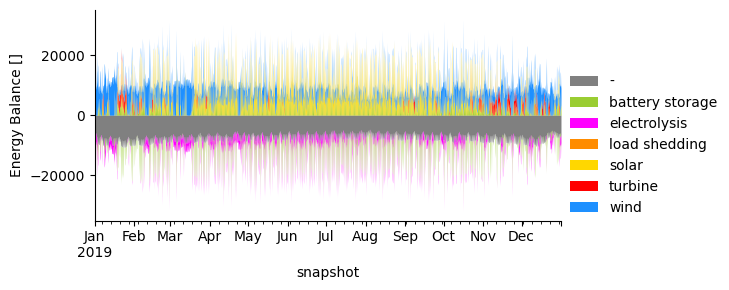

In [18]:
n.statistics.energy_balance.plot.area(linewidth=0, bus_carrier="electricity")